# Содержание

>[Содержание](#scrollTo=jtvKBxJoDhaz)

>>[Домашнее задание](#scrollTo=oS3LfwHrBbpp)

>>[Дополнительные ссылки](#scrollTo=xwCykWqgB4jx)

>>[1 Импорт необходимых библиотек](#scrollTo=ud08SfOpRvC9)

>>[2 Определение необходимых функций](#scrollTo=rKiStZTEUNrS)

>>[3 Загрузка датасетов](#scrollTo=pOHEr5Q-R65Y)

>>>[3.1 Загрузка новостей](#scrollTo=3eyvVQzeWVhs)

>>>[3.2 Загрузка контента пользователей](#scrollTo=rXqISPsTrO0R)

>>>[3.3 Загрузка стоп слов](#scrollTo=vrh_YGaKScNh)

>>[4 Обработка текста](#scrollTo=Vf6UrjmxVYg2)

>>>[4.1 Очистка](#scrollTo=CXIJREZtXVon)

>>>[4.2 Лемматизация](#scrollTo=4alQ6646Xca_)

>>[5 Обучение модели](#scrollTo=8r2ClDZDbmyJ)

>>[6 Сохранение и загрузка модели](#scrollTo=JiE4FJRmhPWL)

>>[7 Проверка модели](#scrollTo=Px8z8TgUcoi1)

>>>[7.1 Обзор тем на содержание](#scrollTo=Admlnr0IczM4)

>>[8 Векторное представление новостей (Взвешивание)](#scrollTo=vRUchP_bdBi_)

>>[9 Векторное преобразование тем(темы/topicks) ползователей (Взвешивание)](#scrollTo=IuomDk2XrO0q)

>>[10 Опреление общей информации о всех пользователях](#scrollTo=0bjsFY35j4Hz)

>>[11 Загрузка датасета оттока клиентов](#scrollTo=o3Z-8dESoROs)

>>[12 Объединение датасетов](#scrollTo=ahJF9oPwpHMf)

>>[13 Разделение на тренировочный и тестовоый датасеты/выборки](#scrollTo=yBnyW6D-pRm4)

>>[14 Обучение модели](#scrollTo=E7YQU5JTpg3H)

>>[15 Сохранение модели](#scrollTo=jVGgNky0qgxg)

>>[16 Просмотр прогнозов для теста](#scrollTo=ync2sqeFpsms)

>>[17 Рассчет Precision, Recall, F_score](#scrollTo=HZ9S0UIGrO0-)

>>[18 Построение матрицы ошибок](#scrollTo=Iqm-mGwCxtar)

>>[19 Сохранение метрик embeding'ов](#scrollTo=daMWjZKb2eT_)

>>[20 TF-IDF](#scrollTo=cbx9_r3dDEdh)



## Домашнее задание

1. *Самостоятельно повторить tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)
3. Повторить п.2, но используя уже не медиану, а max
4. *Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (взяв список новостей пользователя)
    - подсказка 1: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал
    - подсказка 2: нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

## Дополнительные ссылки
1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
3. http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/

Наши новости

https://drive.google.com/file/d/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR

Ссылка на google диск https://drive.google.com/file/d/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a

TF-IDF

https://github.com/codebasics/nlp-tutorials/blob/main/12_tf_idf/tf_idf_tutorial_nlp_codebasics.ipynb

https://www.youtube.com/watch?v=ATK6fm3cYfI

https://github.com/wjbmattingly/topic_modeling_textbook/blob/main/03_03_lda_model_demo_bigrams_trigrams.ipynb

## 1 Импорт необходимых библиотек

In [1]:
!pip install razdel pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=948523e9fe01c301272b1490c98d90e7171eef907cdfa4384d9b9c068c05d330
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
import os
import time
import shutil
import pandas as pd
from google.colab import drive, files
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from tqdm import tqdm
tqdm.pandas()
from gensim.models import LdaModel
from gensim.test.utils import datapath
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2 Определение необходимых функций

In [3]:
def makeDir(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)


def clean_text(text):
    '''
    очистка текста

    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)

    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)

    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)

    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]

    return words_lem_without_stopwords


def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)


def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 3 Загрузка датасетов

In [4]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [5]:
dir_name = "/content/drive/MyDrive/HW2_MOB/"

In [6]:
# makeDir(dir_name)

### 3.1 Загрузка новостей

In [7]:
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O articles.csv && rm -rf /tmp/cookies.txt

In [8]:
path_to_file = dir_name + "articles.csv"

In [9]:
# shutil.move("/content/articles.csv", path_to_file)

In [10]:
news = pd.read_csv(path_to_file)
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [11]:
news.iloc[0]['title']

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утверждение стратегии развития клуба на ближайшую перспективу.nnВ состав совета вошли:nГеоргий Полтавченкоn(полномочный представитель президента в Центральном федеральном округе),nАлексей Седовn(генерал-полковник, начальник службы по защите конституционного строя и борьбе с терроризмомnФСБ РФn),nАлександр Новакn(заместитель министра финансов РФ),nВячеслав Полтавцевn(заместитель генерального директора, руководитель блока по взаимодействию с органами власти, социальной и корпоративной политикиnГМК «Норильский никель»n),nЛеонид Исаковичn(генеральный директор ООО «УК «Спортивные проекты»),nОльга Плешаковаn(генеральный директорn«Трансаэро»n),nАлександр Провоторовn, (генеральный директорnОАО «Ростелеком»n), А

### 3.2 Загрузка контента пользователей

In [12]:
# !wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O users_articles.csv

In [13]:
path_to_second_file = dir_name + "users_articles.csv"

In [14]:
# shutil.move("/content/users_articles.csv", dir_name)

In [15]:
users = pd.read_csv(path_to_second_file)
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 3.3 Загрузка стоп слов

In [16]:
stopword_ru = stopwords.words('russian')

In [17]:
# !wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O "/content/drive/MyDrive/HW2_MOB/stopwords.txt"

In [18]:
path_to_stopwords = "/content/drive/MyDrive/HW2_MOB/stopwords.txt"

In [19]:
with open(path_to_stopwords) as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]

stopword_ru += additional_stopwords
len(stopword_ru)

776

## 4 Обработка текста

### 4.1 Очистка

In [ ]:
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

100%|██████████| 27000/27000 [00:43<00:00, 614.00it/s] 


In [ ]:
news['title'].iloc[:10]

0    [заместитель, председатель, правительство, рф,...
1    [матч, финал, кубок, россия, футбол, приостано...
2    [форвард, авангард, томаш, заборский, прокомме...
3    [главный, тренер, кубань, юрий, красножанин, п...
4    [решение, попечительский, совет, владивостокск...
5    [ио, главное, тренер, вячеслав, буцай, прокомм...
6    [запорожский, металлург, дом, потерпеть, разгр...
7    [сборная, сша, одержать, победа, австрия, счёт...
8    [бывший, защитник, сборная, россия, дарюс, кас...
9    [полузащитник, цска, зоран, тошич, победа, тер...
Name: title, dtype: object

### 4.2 Лемматизация

In [ ]:
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|██████████| 27000/27000 [03:44<00:00, 120.24it/s]


In [ ]:
type(news['title'][0])

list

In [ ]:
# news.to_csv(dir_name + "lemma_news.csv", index=None, )

In [20]:
news = pd.read_csv(dir_name + "lemma_news.csv")

In [21]:
news['title'] = news['title'].apply(lambda x: " ".join([i.strip() for i in x.replace("[","").replace("]","").replace("'","").split(",")]), 1)
news['title'] = news['title'].apply(lambda x: list(x.split(" ")))

In [22]:
news.head(5)

,doc_id,title
0,6,"[заместитель, председатель, правительство, рф,..."
1,4896,"[матч, финал, кубок, россия, футбол, приостано..."
2,4897,"[форвард, авангард, томаш, заборский, прокомме..."
3,4898,"[главный, тренер, кубань, юрий, красножанин, п..."
4,4899,"[решение, попечительский, совет, владивостокск..."


In [23]:
type(news['title'][0])

list

## 5 Обучение модели

In [24]:
"""Формирование списока текстов"""
texts = list(news['title'].values)

In [25]:
"""Создадим корпус из списка с текстами"""
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [26]:
common_dictionary.keys()[0], common_dictionary[0]

(0, 'александр')

In [27]:
common_corpus[0][:10]

[(0, 2),
 (1, 1),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

In [ ]:
N_topic = 20

In [ ]:
"""Обучаем модель на корпусе"""
start = time.time()
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=10)
stop = time.time()
print(f"It is took {round(stop - start, 2)} sec")

It is took 398.53 sec


## 6 Сохранение и загрузка модели

In [ ]:
# makeDir(dir_name + "My_model/")
# temp_file = datapath(dir_name + "My_model/model.lda")
# lda.save(temp_file)

In [29]:
"""Загружаем обученную модель с диска"""
temp_file = dir_name + "My_model/model.lda"
lda = LdaModel.load(temp_file)

In [30]:
"""Создаем новый корпус документов"""
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(1, 0.111794606),
 (5, 0.05109795),
 (6, 0.031141857),
 (9, 0.11207423),
 (13, 0.057696156),
 (18, 0.61761326)]

## 7 Проверка модели

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

### 7.1 Обзор тем на содержание

In [31]:
N_topic = 20
x = lda.show_topics(num_topics=N_topic, num_words=15, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: всё риск очень жизнь газета вопрос большой писать проблема университет школа ребёнок сделать хотеть например
topic_1: рост рынок цена уровень объём составить день вырасти показатель температура население пенсия прогноз выше высокий
topic_2: пациент белоруссия лечение городской рт ожидаться египетский диск зампред госпитализировать ким понятие горожанин чен аркадий
topic_3: северный южный остров космос форум япония вицепремьер автомобиль дальний корея индия снять атмосферный определение казахстан
topic_4: ребёнок женщина мужчина погибнуть тело семья болезнь возраст жизнь жертва конкурс фильм летний умереть память
topic_5: участок мальчик золото лесной убивать аргентина киргизия золотой рот казань переносить материал застрять счёт эндрю
topic_6: сотрудник обнаружить область москва район данные информация орган служба уголовный задержать сообщение убийство бывший связь
topic_7: сша военный американский сила армия российский боевой турция действие оборона россия удар государство т

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

## 8 Векторное представление новостей (Взвешивание)

In [ ]:
"""Для темы 0"""
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.52436763, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01001882, 0.32697305, 0.        ,
       0.        , 0.        , 0.        , 0.13101265, 0.        ])

In [41]:
start = time.time()
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
stop = time.time()
print(f"Converting the entire dataset into a vector representation took {round(stop - start, 2)} sec")
topic_matrix.head(5)

Converting the entire dataset into a vector representation took 42.02 sec


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.524354,0.0,0.0,...,0.0,0.0,0.010019,0.326988,0.000000,0.0,0.0,0.0,0.131012,0.000000
1,4896,0.000000,0.000000,0.0,0.0,0.0,0.074585,0.103140,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.109876,0.0,0.0,0.0,0.314722,0.377906
2,4897,0.000000,0.111792,0.0,0.0,0.0,0.051096,0.031095,0.0,0.0,...,0.0,0.0,0.000000,0.057709,0.000000,0.0,0.0,0.0,0.617651,0.000000
3,4898,0.160262,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.248818,0.134565,0.0,0.0,0.0,0.446074,0.000000
4,4899,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.037868,0.733044,0.000000,0.0,0.0,0.0,0.204042,0.000000


In [42]:
topic_matrix.to_csv(dir_name + "vectors_topic_matrix.csv", index=None)

In [43]:
topic_matrix = pd.read_csv(dir_name + "vectors_topic_matrix.csv")
# topic_matrix.drop("Unnamed: 0", axis=1, inplace=True)
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.524354,0.0,0.0,...,0.0,0.0,0.010019,0.326988,0.000000,0.0,0.0,0.0,0.131012,0.000000
1,4896,0.000000,0.000000,0.0,0.0,0.0,0.074585,0.103140,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.109876,0.0,0.0,0.0,0.314722,0.377906
2,4897,0.000000,0.111792,0.0,0.0,0.0,0.051096,0.031095,0.0,0.0,...,0.0,0.0,0.000000,0.057709,0.000000,0.0,0.0,0.0,0.617651,0.000000
3,4898,0.160262,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.248818,0.134565,0.0,0.0,0.0,0.446074,0.000000
4,4899,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.037868,0.733044,0.000000,0.0,0.0,0.0,0.204042,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

## 9 Векторное преобразование тем(темы/topicks) ползователей (Взвешивание)

In [59]:
users.head(5)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [45]:
"""Определение словаря, где:
    ключ - это номер темы, которую просматривал пользователь
    значение - векторное представление темы"""
"""Determination of dictionary, where:
    key is number of topic which was read
    value is vector representation the topic"""
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [46]:
doc_dict[293672]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.29492959, 0.        , 0.        , 0.        ,
       0.13715461, 0.16114755, 0.        , 0.        , 0.03457578,
       0.        , 0.        , 0.02917112, 0.32355675, 0.        ])

## 10 Опреление общей информации о всех пользователях

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [47]:
start = time.time()
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
stop = time.time()
print(f"Converting the entire dataset into a vector representation took {round(stop - start, 2)} sec")
user_embeddings.head(3)

Converting the entire dataset into a vector representation took 0.38 sec


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.117645,0.000000,0.089082,0.000000,0.137903,0.027915,0.294930,0.107568,0.033709,...,0.137155,0.308382,0.000000,0.667591,0.152537,0.000000,0.121888,0.029171,0.323926,0.280137
1,u108690,0.315338,0.070290,0.000000,0.029077,0.080315,0.000000,0.431038,0.064172,0.000000,...,0.000000,0.238466,0.000000,0.518841,0.084685,0.037603,0.115876,0.000000,0.136919,0.236425
2,u108339,0.104800,0.178401,0.018708,0.012745,0.066152,0.000000,0.294392,0.153122,0.017238,...,0.078999,0.212779,0.018852,0.417778,0.065766,0.035842,0.069161,0.010284,0.122914,0.315274


In [48]:
# user_embeddings.to_csv(dir_name + "embeding_of_users.csv", index=None)

## 11 Загрузка датасета оттока клиентов

In [49]:
user_embeddings = pd.read_csv(dir_name + "embeding_of_users.csv")

Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

https://drive.google.com/file/d/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK

In [50]:
user_embeddings.head(5)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.117645,0.000000,0.089082,0.000000,0.137903,0.027915,0.294930,0.107568,0.033709,...,0.137155,0.308382,0.000000,0.667591,0.152537,0.000000,0.121888,0.029171,0.323926,0.280137
1,u108690,0.315338,0.070290,0.000000,0.029077,0.080315,0.000000,0.431038,0.064172,0.000000,...,0.000000,0.238466,0.000000,0.518841,0.084685,0.037603,0.115876,0.000000,0.136919,0.236425
2,u108339,0.104800,0.178401,0.018708,0.012745,0.066152,0.000000,0.294392,0.153122,0.017238,...,0.078999,0.212779,0.018852,0.417778,0.065766,0.035842,0.069161,0.010284,0.122914,0.315274
3,u101138,0.302625,0.091878,0.051205,0.051057,0.055129,0.571020,0.038344,0.023989,0.035574,...,0.091945,0.000000,0.051029,0.162700,0.311105,0.051524,0.051657,0.012079,0.688868,0.188911
4,u108248,0.343084,0.498376,0.078766,0.020151,0.026071,0.000000,0.203352,0.036030,0.000000,...,0.000000,0.082024,0.045077,0.668666,0.201025,0.010837,0.050625,0.010829,0.209317,0.246261


In [51]:
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.524354,0.0,0.0,...,0.0,0.0,0.010019,0.326988,0.000000,0.0,0.0,0.0,0.131012,0.000000
1,4896,0.000000,0.000000,0.0,0.0,0.0,0.074585,0.103140,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.109876,0.0,0.0,0.0,0.314722,0.377906
2,4897,0.000000,0.111792,0.0,0.0,0.0,0.051096,0.031095,0.0,0.0,...,0.0,0.0,0.000000,0.057709,0.000000,0.0,0.0,0.0,0.617651,0.000000
3,4898,0.160262,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.248818,0.134565,0.0,0.0,0.0,0.446074,0.000000
4,4899,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.037868,0.733044,0.000000,0.0,0.0,0.0,0.204042,0.000000


In [ ]:
# !wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O "/content/drive/MyDrive/HW2_MOB/users_churn.csv"

In [ ]:
path_to_target_data = "/content/drive/MyDrive/HW2_MOB/users_churn.csv"

In [ ]:
target = pd.read_csv(path_to_target_data)
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


## 12 Объединение датасетов

In [ ]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,Unnamed: 0,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,0,u105138,0.117662,0.000000,0.089082,0.000000,0.137897,0.027914,0.294930,0.107589,...,0.308330,0.000000,0.667693,0.152539,0.000000,0.121889,0.029171,0.323948,0.280137,0
1,1,u108690,0.315345,0.070290,0.000000,0.029077,0.080315,0.000000,0.431011,0.064171,...,0.238466,0.000000,0.520448,0.084702,0.037652,0.115876,0.000000,0.131035,0.236424,1
2,2,u108339,0.104798,0.178385,0.018706,0.012746,0.066152,0.000000,0.294388,0.153122,...,0.213221,0.018853,0.417769,0.065761,0.035842,0.069161,0.010284,0.122947,0.315277,1


## 13 Разделение на тренировочный и тестовоый датасеты/выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]],
                                                    X['churn'], random_state=0, stratify=X['churn'],
                                                    test_size=0.25)

## 14 Обучение модели

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

## 15 Сохранение модели

In [ ]:
name_dir_for_model = "My_model_2/"
name_model = "log_reg_model.sav"
path_to_model = dir_name + name_dir_for_model + name_model

In [ ]:
# makeDir(dir_name + name_dir_for_model)

In [ ]:
"""Save"""
# with open(path_to_model, "wb") as f:
#     pickle.dump(logreg, f)

In [ ]:
"""Load"""
with open(path_to_model, "rb") as f:
    logreg = pickle.load(f)

## 16 Просмотр прогнозов для теста

In [ ]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:20]

array([4.73216521e-02, 4.16608907e-02, 4.27551069e-04, 4.84818444e-02,
       4.40553465e-02, 1.59245427e-01, 2.42458001e-02, 2.04747400e-01,
       2.17892704e-01, 5.15140035e-05, 1.53259336e-05, 2.20349095e-02,
       2.68081398e-02, 1.09566651e-01, 3.47247289e-01, 8.04681109e-02,
       5.12071911e-03, 2.54784738e-03, 5.44223404e-02, 5.25805326e-03])

## 17 Рассчет Precision, Recall, F_score

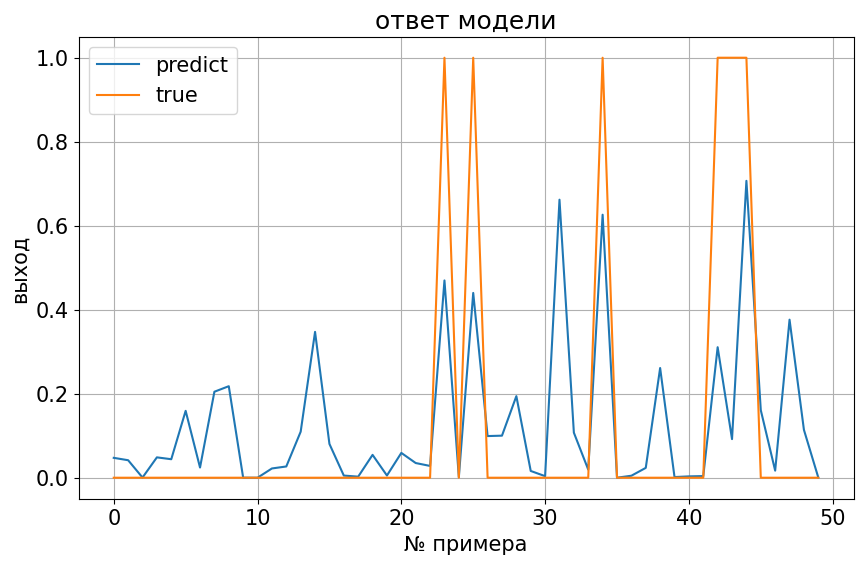

In [ ]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3824888149763084, F-Score=0.703, Precision=0.762, Recall=0.652


## 18 Построение матрицы ошибок

Confusion matrix, without normalization
[[1699   51]
 [  88  162]]


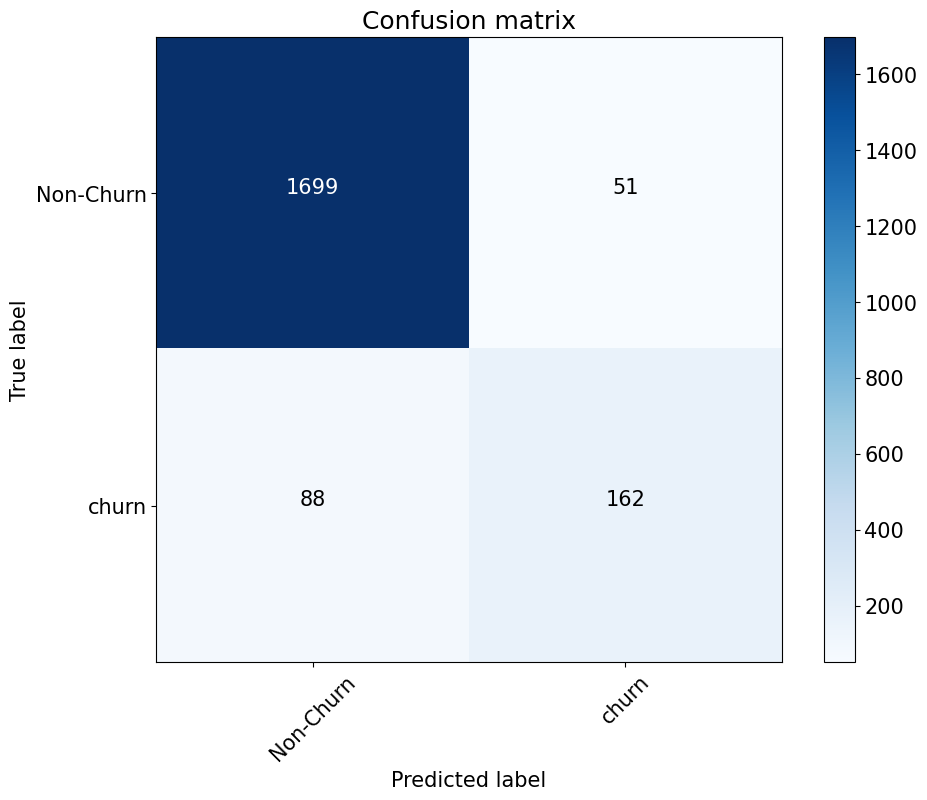

In [ ]:
import itertools
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig(dir_name + "conf_matrix.png")
plt.show()

In [ ]:
roc_auc = roc_auc_score(y_test, preds)

## 19 Сохранение метрик embeding'ов

In [ ]:
max_test = {"roc_auc": roc_auc, "precision": precision[ix], "recall": recall[ix], "thresholds": thresholds[ix], "fscore": fscore[ix]}

In [ ]:
df_max_test = pd.DataFrame(max_test, index=[0])

In [ ]:
# df_median_test.to_csv(dir_name + "median_test.csv", sep=",")

In [ ]:
# df_max_test.to_csv(dir_name + "max_test.csv", sep=",")

In [ ]:
df_median_test = pd.read_csv(dir_name + "median_test.csv", sep=",")
df_max_test = pd.read_csv(dir_name + "max_test.csv", sep=",")

In [ ]:
df_median_test.drop("Unnamed: 0", axis=1, inplace=True)
df_max_test.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
df_max_test

,roc_auc,precision,recall,thresholds,fscore
0,0.942807,0.761682,0.652,0.382489,0.702586


In [ ]:
df_median_test

,roc_auc,precision,recall,thresholds,fscore
0,0.94789,0.604361,0.776,0.257769,0.67951


In [ ]:
df = pd.concat([df_median_test, df_max_test], ignore_index=True)

In [ ]:
df["embeding"] = ["median_test", "max_test"]
df

,roc_auc,precision,recall,thresholds,fscore,embeding
0,0.947890,0.604361,0.776,0.257769,0.679510,median_test
1,0.942807,0.761682,0.652,0.382489,0.702586,max_test


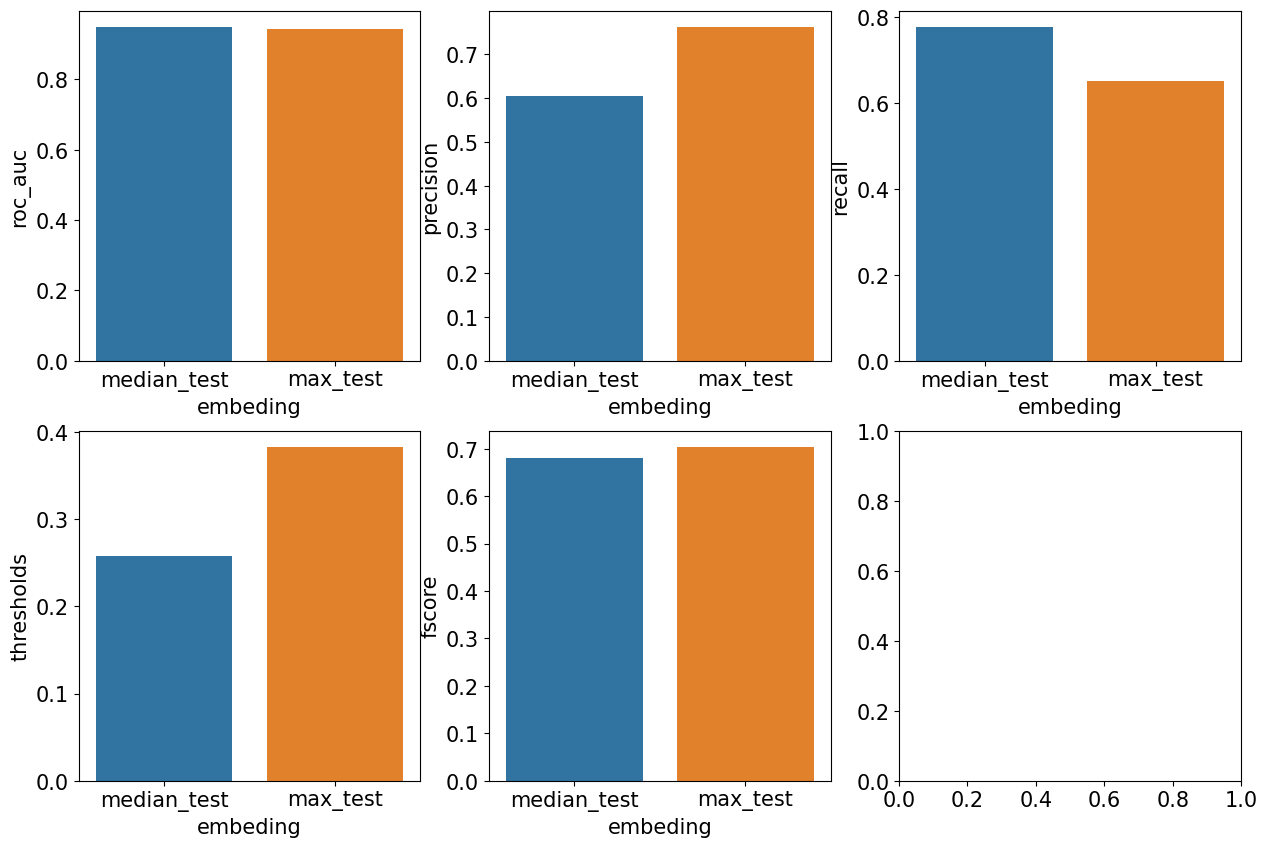

In [ ]:
fig, axx = plt.subplots(2, 3, figsize=(15,10))
count = 0
for i in range(2):
    for j in range(3):
        if (j == 2) and (i == 1):
            break
        sns.barplot(data=df, x=df['embeding'], y=df[df.columns[count]], ax=axx[i,j])
        count += 1

## 20 TF-IDF

In [53]:
news_idf = pd.read_csv(dir_name + "lemma_news.csv")

In [54]:
news_idf['title'] = news_idf['title'].apply(lambda x: " ".join([i.strip() for i in x.replace("[","").replace("]","").replace("'","").split(",")]), 1)
# news_idf['title'] = news_idf['title'].apply(lambda x: list(x.split(" ")))
news_idf['title'].head(5)

0    заместитель председатель правительство рф серг...
1    матч финал кубок россия футбол приостановить с...
2    форвард авангард томаш заборский прокомментиро...
3    главный тренер кубань юрий красножанин прокомм...
4    решение попечительский совет владивостокский с...
Name: title, dtype: object

In [55]:
tfidf = TfidfVectorizer()
transforms_output = tfidf.fit_transform(news_idf['title'])

In [56]:
idf_news = pd.DataFrame({"title_id": tfidf.get_feature_names_out(),
                         "idf": tfidf.idf_})

In [58]:
idf_news['title_id']

0              aa
1             aaa
2            aaas
3           aabar
4           aacsb
           ...   
135506         ⁰с
135507       ただいま
135508       ちーはら
135509    仲良しぱくぱく
135510         黒人
Name: title_id, Length: 135511, dtype: object

In [60]:
users_idf = users

In [62]:
users_idf['articles'] = users_idf['articles'].apply(lambda x: " ".join([i.strip() for i in x.replace("[","").replace("]","").replace("'","").split(",")]), 1)
# users_idf['articles'] = users_idf['articles'].apply(lambda x: list(x.split(" ")))
users_idf['articles'].head(5)

0    293672 293328 293001 293622 293126 1852
1            3405 1739 2972 1158 1599 322665
2            1845 2009 2356 1424 2939 323389
3            5933 6186 5055 6977 5206 488389
4             707 1144 2532 2928 3133 324592
Name: articles, dtype: object

In [63]:
tfidf.fit(users_idf['articles'])
idf_users = pd.DataFrame({"articles_id": tfidf.get_feature_names_out(),
                         "idf": tfidf.idf_})

In [65]:
idf_users.head(10)

,articles_id,idf
0,10,8.888710
1,100,7.907880
2,1000,8.041412
3,1001,8.888710
4,1002,8.888710
5,1003,8.041412
6,1005,8.601027
7,1006,9.294175
8,1007,9.294175
9,1008,9.294175


In [87]:
idf_users[idf_users['articles_id'] == "293672"]

,articles_id,idf
2848,293672,8.601027
